# Trabalho Prático II
# POS Tagging para a língua Portuguesa

### Thaís Ferreira da Silva - 2021092571
___

O objetivo do trabalho  é implementar e avaloiar um modelo de POS Taggind para a língua portuguesa utilizando o corpus Mac-Morpho. 

Para essa tarefa escolhi o modelo pré-treinado de Transformers (BERT) devido ao seu desempenho superior em tarefas de NLP graças à sua capacidade de capturar dependências contextuais

## Ferramentas Utilizadas

Frameworks e Pacotes
- **Transformers (Hugging Face):** Usado para acessar o modelo pré-treinado bert-base-portuguese-cased e realizar tokenização e classificação de tokens.

- **PyTorch:** Biblioteca para construir o pipeline de treinamento, cálculo de loss, e inferência.

- **Datasets:** Para carregar e manipular os conjuntos de dados fornecidos.

- **scikit-learn (LabelEncoder):** Para codificar e decodificar as tags de POS.

- **Seaborn e Matplotlib:** Para visualização dos resultados.

- **CSV:** Para salvar resultados detalhados da análise das previsões.

Corpus
- **Mac-Morpho:** Fornece os dados anotados de POS para treinamento, validação e teste.

In [19]:
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler, Trainer, TrainingArguments, AdamW

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from datasets import load_dataset
from datasets import Dataset
import csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Funções Auxiliares

A função load_data é utilizada para carregar os dados do corpus a partir de um arquivo. Ela percorre cada linha do arquivo, separando palavras e suas respectivas tags, que estão unidas por um sublinhado (_). Essas informações são armazenadas em duas listas: sentences, que contém os tokens, e labels, que contém as tags correspondentes. Por fim, as listas são retornadas para posterior processamento.

In [132]:
# Função para carregar os dados
def load_data(filepath):
    sentences = []
    labels = []
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            tokens, tags = [], []
            for pair in line.strip().split():
                word, tag = pair.rsplit("_", 1)
                tokens.append(word)
                tags.append(tag)
            sentences.append(tokens)
            labels.append(tags)
    return sentences, labels

A função preprocess, por sua vez, realiza o pré-processamento das sentenças e tags para adequá-las ao modelo BERT. Ela tokeniza as frases usando o tokenizer do BERT, garantindo que cada sentença seja truncada ou preenchida com padding para um comprimento máximo de 128 tokens. As tags são ajustadas para corresponder aos sub-tokens gerados pelo tokenizer, sendo que os sub-tokens adicionais recebem o valor -100 para que sejam ignorados no treinamento. As tags também são transformadas em IDs utilizando um LabelEncoder.

In [133]:
def preprocess(sentences, tags, tokenizer, tag_encoder):
    input_ids, attention_masks, labels = [], [], []

    for sentence, tag_seq in zip(sentences, tags):
        # Tokenizar as frases
        encoding = tokenizer(
            sentence,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        # Ajustar os rótulos para sub-tokens
        word_ids = encoding.word_ids()
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorar sub-tokens fora da sequência
            elif word_idx != previous_word_idx:
                label_ids.append(tag_encoder.transform([tag_seq[word_idx]])[0])
            else:
                label_ids.append(-100)  # Ignorar sub-tokens adicionais

            previous_word_idx = word_idx

        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])
        labels.append(torch.tensor(label_ids))

    return torch.cat(input_ids), torch.cat(attention_masks), torch.stack(labels)

A função create_dataloader é responsável por criar um DataLoader usando PyTorch, que organiza os dados em lotes para facilitar o treinamento e avaliação do modelo. Ela recebe os tensores de IDs dos tokens, máscaras de atenção e rótulos, e utiliza essas informações para criar um TensorDataset, retornando um DataLoader configurado com o tamanho de lote especificado.

In [134]:
def create_dataloader(inputs, masks, labels, batch_size=16):
    data = TensorDataset(inputs, masks, labels)
    return DataLoader(data, batch_size=batch_size)

A função compute_metrics calcula métricas de desempenho, como a acurácia. Ela é utilizada durante o processo de treino para validar os resultados obtidos.

In [135]:
def compute_metrics(eval_pred, label_encoder):
    logits, labels = eval_pred

    # Garantir que logits e labels sejam tensores PyTorch
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(logits)

    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)

    # Calcular previsões
    predictions = torch.argmax(logits, dim=-1).flatten().numpy()
    labels = labels.flatten().numpy()

    # Ignorar sub-tokens, onde a label é -100
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]

    accuracy = accuracy_score(labels, predictions)

    # Print a palavra, o predict e o label
    for i in range(len(labels)):
        pred_label = label_encoder.inverse_transform([predictions[i]])[0]
        true_label = label_encoder.inverse_transform([labels[i]])[0]

    # Adicionar outras métricas, se necessário
    return {"accuracy": accuracy}


A função create_hf_dataset converte os dados pré-processados para o formato esperado pelo framework Hugging Face.

In [136]:
def create_hf_dataset(inputs, masks, labels):
    data = {
        "input_ids": inputs.tolist(),
        "attention_mask": masks.tolist(),
        "labels": labels.tolist(),
    }
    return Dataset.from_dict(data)

A função save_model salva o modelo treinado e o tokenizer no disco facilitando futuras analises.

In [137]:
def save_model(model, tokenizer, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    model.save_pretrained(save_directory)
    tokenizer.save_pretrained(save_directory)
    print(f"Modelo salvo em: {save_directory}")

## Pré-processamento e riação do Modelo

O processo de pré-processamento começou com a extração das sentenças e suas tags diretamente do corpus, usando a função load_data. Depois, fiz a tokenização com o BertTokenizerFast, ajustando para garantir que os sub-tokens fossem corretamente associados às tags originais, mantendo a coerência dos dados.

Para preparar as tags para o modelo, usei o LabelEncoder, que converteu as etiquetas textuais em números, permitindo que o modelo de aprendizado de máquina trabalhasse com elas.

Na criação do modelo, optei pelo bert-base-portuguese-cased, uma versão robusta do BERT adaptada para classificação de tokens. Defini o número de classes com base no total de tags do corpus, garantindo que o modelo conseguisse lidar bem com a variedade de etiquetas.

In [138]:
# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caminhos para os arquivos de dados
train_file = "./corpus/macmorpho-train.txt"
val_file = "./corpus/macmorpho-dev.txt"
test_file = "./corpus/macmorpho-test.txt"

data_files = {
    "train": train_file,
    "validation": val_file,
    "test": test_file,
}

# Carregar os dados
tokens_train, tags_train = load_data(train_file)
tokens_val, tags_val = load_data(val_file)
tokens_test, tags_test = load_data(test_file)

# Inicializar o tokenizer e o modelo pré-treinado
tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")
num_classes = len(set(tag for sent_tags in tags_train for tag in sent_tags))

model = BertForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=num_classes
).to(device)

# Label Encoder para as tags
tag_encoder = LabelEncoder()
tag_encoder.fit([tag for sent_tags in tags_train for tag in sent_tags])

# Pré-processar os dados
train_inputs, train_masks, train_labels = preprocess(tokens_train, tags_train, tokenizer, tag_encoder)
val_inputs, val_masks, val_labels = preprocess(tokens_val, tags_val, tokenizer, tag_encoder)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Treinamento

Para o treinamento do modelo, precisei prestar atenção aos parâmetros e configurações para garantir que o modelo fosse bem ajustado à tarefa de POS Tagging. Para isso, usei o TrainingArguments, onde defini os hiperparâmetros essenciais. Entre eles, destaco:

- **Número de épocas:** Escolhi um valor adequado para garantir que o modelo tivesse tempo suficiente para aprender padrões importantes no corpus, sem risco de sobreajuste.
- **Taxa de aprendizado:** Defini um valor moderado para controlar a velocidade de atualização dos pesos durante o treinamento.
- **Tamanho do batch:** Ajustei o tamanho do batch para equilibrar eficiência computacional e capacidade de generalização. Um batch menor ajuda a fazer ajustes mais precisos.

A taxa de aprendizado foi ajustada para evitar oscilações durante a convergência, enquanto o tamanho do batch foi configurado para otimizar o uso da memória da GPU sem prejudicar o desempenho.

O treinamento foi realizado com o conjunto de dados preparado anteriormente, e vale mencionar que usei apenas 2/4 do arquivo de teste devido às limitações da minha máquina.

Durante o treinamento, acompanhei a acurácia para avaliar o desempenho do modelo de forma detalhada.

In [139]:
PATH = "./training_output"

# Criar os DataLoaders
train_dataloader = create_dataloader(train_inputs, train_masks, train_labels) #usar para treinar
test_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para testar
val_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para validar

# Definir o otimizador
optimizer = AdamW(model.parameters(), lr=5e-5)
unique_labels = tag_encoder.classes_

# Supondo que os arquivos estejam no formato linha por linha (ajuste o formato, se necessário)
datasets = load_dataset("text", data_files=data_files)

# Criar datasets no formato esperado
train_dataset = create_hf_dataset(train_inputs, train_masks, train_labels)
train_dataset = train_dataset.select(range(20000))  # Usar apenas 20.000 exemplos para acelaerar o treinamento

test_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)
val_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)


In [140]:
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=PATH,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_dir=f"{PATH}/log",
    save_total_limit=2,
    logging_steps=10,
    fp16=True,
)

# Limpar cache da GPU
torch.cuda.empty_cache()

# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Dataset de treinamento
    eval_dataset=test_dataset,     # Dataset de test
    optimizers=(optimizer, None),  # Passando o otimizador
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, label_encoder),
)

# Iniciar o treinamento
trainer.train()

# Salvar o modelo após o treinamento
save_directory = "./saved_model"
save_model(model, tokenizer, save_directory)

Step,Training Loss,Validation Loss,Accuracy
50,0.224100,0.200893,0.954939
100,0.109000,0.117722,0.972892
150,0.094200,0.100854,0.974898
200,0.076700,0.090974,0.977367
250,0.074800,0.086122,0.978421
300,0.075200,0.084827,0.978498


Modelo salvo em: ./saved_model


## Avaliação e Resultados

Depois que o treinamento acabou, avaliei o modelo usando um conjunto de validação, que estava separado do conjunto de treinamento. Os principais passos e métricas da avaliação foram os seguintes:

- **Inferência no conjunto de validação:** Usei o modelo para fazer previsões, token por token, no dataset de validação, gerando as tags previstas para cada sentença.
- **Cálculo de métricas de desempenho:** Para avaliar o desempenho, optei pela acurácia, que já usei no TP1 e trouxe bons resultados. Ela considera a proporção de tags corretamente previstas no total de tokens.
- **Análise de erros:** Fiz uma análise qualitativa dos erros, tentando identificar padrões de confusão entre as classes.
- **Impacto das tags raras:** Dei atenção especial às tags menos frequentes no corpus, já que elas tendem a ser mais difíceis para o modelo.

In [141]:
# Inicializando variáveis para armazenar os resultados
all_predictions = []
all_labels = []
sentence_accuracy = []  # Acurácia para cada sentença
word_accuracy = []  # Acurácia para cada palavra
print_count = 0
max_print = 10  # Defina o número de exemplos que você deseja imprimir
printNum = 0;

output_csv = "./resultados_analise_completa.csv"

# Abrir o arquivo CSV para escrita
with open(output_csv, "w", newline='', encoding="utf-8") as csvfile:
    fieldnames = ['Sentence', 'Word', 'Predicted Tags', 'True Tags', 'Sentence Accuracy', 'Word Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()  # Escrever os cabeçalhos

    # Avaliação nos conjuntos de validação e teste
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:  # Você pode trocar por test_dataloader, se necessário
            batch_input_ids, batch_masks, batch_labels = [b.to(device) for b in batch]
            
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch_labels.cpu().numpy()

            # Ignorar tokens -100
            for pred, label, input_ids in zip(predictions, labels, batch_input_ids):
                mask = label != -100
                pred = pred[mask]
                label = label[mask]
                input_ids = input_ids[mask].cpu().numpy()  # Selecionando apenas os ids de tokens relevantes

                all_predictions.extend(pred)
                all_labels.extend(label)

                # Decodificar os ids para obter as palavras
                words = tokenizer.decode(input_ids, skip_special_tokens=True).split()

                # Transformar as previsões e rótulos para as tags
                predicted_tags = tag_encoder.inverse_transform(pred)
                true_tags = tag_encoder.inverse_transform(label)

                # Calcular a acurácia para cada palavra e para a sentença
                correct_tags = sum([1 if p == t else 0 for p, t in zip(predicted_tags, true_tags)])
                sentence_accuracy.append(correct_tags / len(predicted_tags))  # Acurácia por sentença

                # Imprimir a sentença apenas uma vez
                if printNum == 0 and (print_count < max_print):
                    print(f"Sentence: {' '.join(words)}")
                    print_count += 1

                # Iterar pelas palavras para calcular a acurácia por palavra
                for word, p, t in zip(words, predicted_tags, true_tags):
                    word_accuracy.append(1 if p == t else 0)  # Se o predito for igual ao verdadeiro, é um acerto

                    # Salvar as informações no CSV
                    writer.writerow({
                        'Sentence': ' '.join(words),
                        'Word': word,
                        'Predicted Tags': p,
                        'True Tags': t,
                        'Sentence Accuracy': correct_tags / len(predicted_tags),  # Acurácia por sentença
                        'Word Accuracy': 1 if p == t else 0  # 1 para acerto, 0 para erro na palavra
                    })

                    if printNum == 0 and (print_count < max_print):
                        print(f"Word: {word.ljust(20)} || Predicted Tags: {p.ljust(10)} || True Tags: {t.ljust(10)}")
                        
                printNum = 1

    # Calcular a acurácia geral (considerando as acurácias por palavra e por sentença)
    total_sentence_accuracy = sum(sentence_accuracy) / len(sentence_accuracy)
    total_word_accuracy = sum(word_accuracy) / len(word_accuracy)
    
    print(f"Sentence-level Accuracy: {total_sentence_accuracy:.4f}")
    print(f"Word-level Accuracy: {total_word_accuracy:.4f}")

print(f"Análise salva em: {output_csv}")


Sentence: Ainda em dezembro de 1990, foi editada a famosa 28, que mod a sistemática da arrecadação do I e alter suas al.
Word: Ainda                || Predicted Tags: ADV        || True Tags: ADV       
Word: em                   || Predicted Tags: PREP       || True Tags: PREP      
Word: dezembro             || Predicted Tags: N          || True Tags: N         
Word: de                   || Predicted Tags: PREP       || True Tags: PREP      
Word: 1990,                || Predicted Tags: N          || True Tags: N         
Word: foi                  || Predicted Tags: PU         || True Tags: PU        
Word: editada              || Predicted Tags: V          || True Tags: V         
Word: a                    || Predicted Tags: PCP        || True Tags: PCP       
Word: famosa               || Predicted Tags: ART        || True Tags: ART       
Word: 28,                  || Predicted Tags: ADJ        || True Tags: ADJ       
Word: que                  || Predicted Tags: N          ||

#### 1. Acurácia
Os resultados mostram uma ótima performance, com a acurácia das sentenças em torno de 0.96 e das palavras cerca de 0.97. O gráfico de Acurácia das Sentenças: Predições vs. Etiquetas Verdadeiras revela que, na maioria das sentenças, o modelo alcançou mais de 80% de acurácia, com apenas alguns casos abaixo disso. Mesmo em sentenças mais longas, onde há mais variação nas predições, o modelo manteve bons resultados, mostrando sua robustez.

Decidi incluir um gráfico que combina a perda (Loss) de treinamento e validação com a acurácia (Accuracy) ao longo dos passos de treinamento. Isso ajuda a analisar a relação entre a diminuição da perda e o aumento da acurácia, dando uma visão mais completa da convergência do modelo. O gráfico mostra que o modelo teve uma melhoria constante até cerca de 250 steps, quando entrou em estagnação e, após esse ponto, começou a apresentar uma leve piora na validação e na acurácia. Esse comportamento sugere o início de overfitting, indicando que seria ideal interromper o treinamento nesse momento para evitar que o desempenho do modelo se degrade.

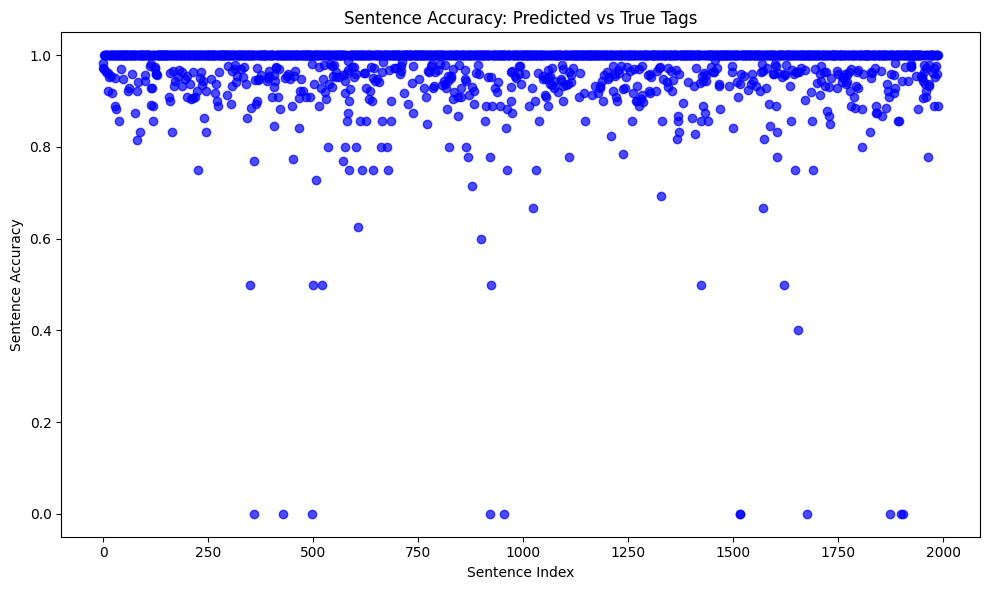

In [35]:
df = pd.read_csv("./resultados_analise_completa.csv")

sentence_accuracy = df.groupby('Sentence')['Sentence Accuracy'].first()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(sentence_accuracy)), sentence_accuracy, color='blue', alpha=0.7)
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Accuracy')
plt.title('Sentence Accuracy: Predicted vs True Tags')
plt.tight_layout()
plt.show()

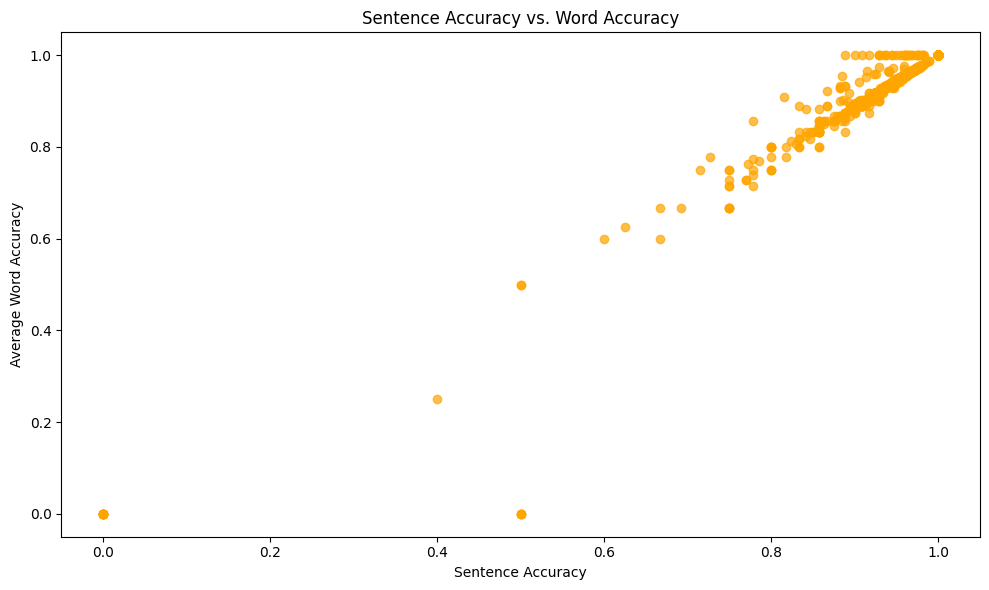

In [36]:
word_accuracy_by_sentence = df.groupby('Sentence')['Word Accuracy'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(sentence_accuracy, word_accuracy_by_sentence, color='orange', alpha=0.7)
plt.xlabel('Sentence Accuracy')
plt.ylabel('Average Word Accuracy')
plt.title('Sentence Accuracy vs. Word Accuracy')
plt.tight_layout()
plt.show()

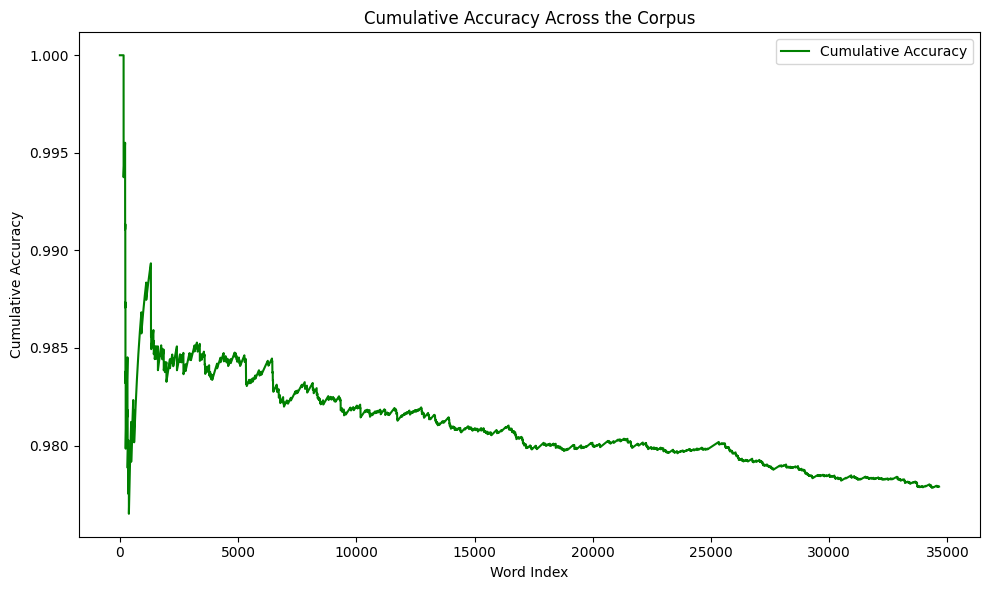

In [37]:
df['Cumulative Accuracy'] = df['Word Accuracy'].expanding().mean()

plt.figure(figsize=(10, 6))
plt.plot(df['Cumulative Accuracy'], label='Cumulative Accuracy', color='green')
plt.xlabel('Word Index')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Across the Corpus')
plt.legend()
plt.tight_layout()
plt.show()

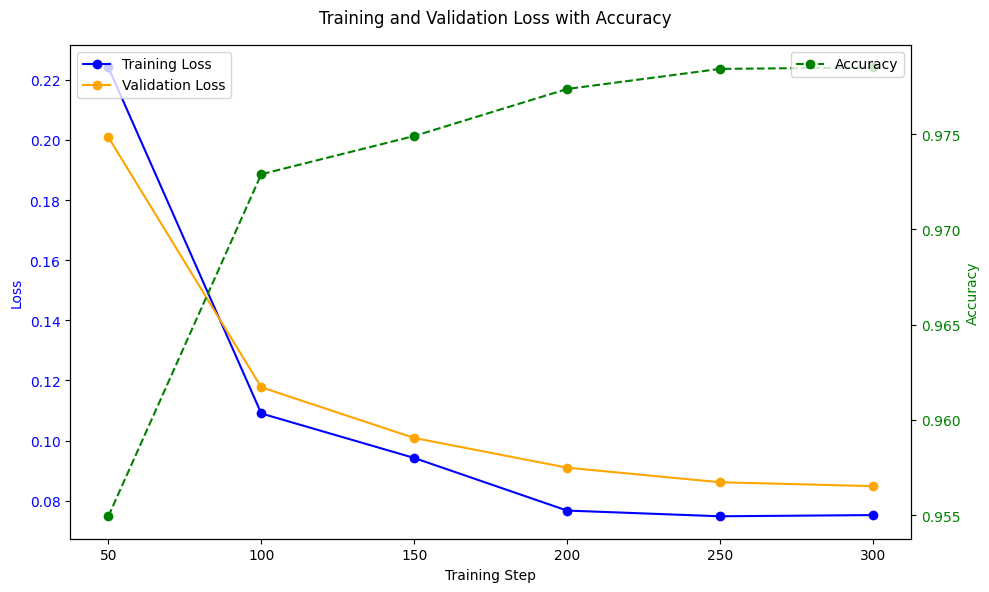

In [38]:
accuracy = [0.954939, 0.972892, 0.974898, 0.977367, 0.978421, 0.978498]

steps = [50, 100, 150, 200, 250, 300]
training_loss = [0.224100, 0.109000, 0.094200, 0.076700, 0.074800, 0.075200]
validation_loss = [0.200893, 0.117722, 0.100854, 0.090974, 0.086122, 0.084827]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(steps, training_loss, label='Training Loss', marker='o', color='blue', linestyle='-')
ax1.plot(steps, validation_loss, label='Validation Loss', marker='o', color='orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='green')
ax2.plot(steps, accuracy, label='Accuracy', marker='o', color='green', linestyle='--')
ax2.tick_params(axis='y', labelcolor='green')

fig.suptitle('Training and Validation Loss with Accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()


#### 2. Tags e classes gramaticais

Ao analisar as classes gramaticais com base nas etiquetas do Mac-Morpho, percebi que a precisão do modelo varia bastante de uma classe para outra. 

**Classes de maior precisão**

As classes com maior precisão tendem a ter regras bem definidas e aparecem mais no corpus. Alguns exemplos são:

- CUR (símbolo de moeda): Fácil de identificar por ser específica.
- PU (pontuação): Regras simples e pouca ambiguidade.
- PROPESS (pronome pessoal): Bem definido e fácil de classificar.
- V (verbo): Alta frequência e regras claras favorecem sua identificação.

**Classes de menor precisão**

Já as classes com menor precisão têm mais ambiguidade ou aparecem menos no corpus. Alguns exemplos são:

- PREP+ADV (preposição + advérbio): Difícil de diferenciar sem contexto.
- PREP+PRO-KS (preposição + pronome relativo): Exige análise sintática detalhada.
- IN (interjeição): Pouco frequente e dependente do contexto.

**Relação entre frequência e precisão**

Uma observação interessante é que as classes mais frequentes, como N (nome), V (verbo) e ART (artigo), tendem a ter uma precisão mais alta, já as menos frequentes, como ADV-KS (advérbio conectivo subordinativo) e PREP+ADV, acabam ficando com uma precisão mais baixa.

Vale ressaltar também que, apesar das palavras mais frequentes terem uma precisão maior, o modelo acaba cometendo mais erros nelas justamente por elas aparecerem com mais frequência nos testes.

In [39]:
df['Sentence Accuracy'] = pd.to_numeric(df['Sentence Accuracy'], errors='coerce')
df['Word Accuracy'] = pd.to_numeric(df['Word Accuracy'], errors='coerce')

df.head()

,Sentence,Word,Predicted Tags,True Tags,Sentence Accuracy,Word Accuracy,Cumulative Accuracy
0,"Ainda em dezembro de 1990, foi editada a famos...",Ainda,ADV,ADV,1.0,1,1.0
1,"Ainda em dezembro de 1990, foi editada a famos...",em,PREP,PREP,1.0,1,1.0
2,"Ainda em dezembro de 1990, foi editada a famos...",dezembro,N,N,1.0,1,1.0
3,"Ainda em dezembro de 1990, foi editada a famos...",de,PREP,PREP,1.0,1,1.0
4,"Ainda em dezembro de 1990, foi editada a famos...","1990,",N,N,1.0,1,1.0


C:\Users\thais\AppData\Local\Temp\ipykernel_6904\3633149598.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word Accuracy', y='True Tags', data=tag_accuracy, palette='viridis')


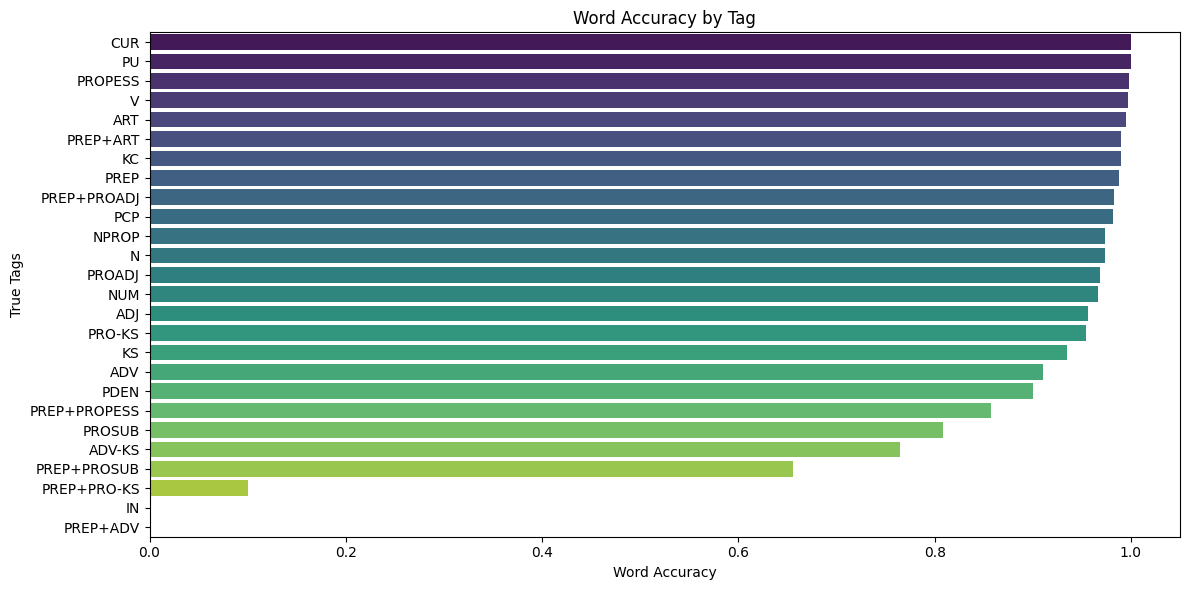

In [40]:
df2 = df.drop(columns=['Sentence'])
tag_accuracy = df2.groupby('True Tags')['Word Accuracy'].mean().reset_index()
tag_accuracy = tag_accuracy.sort_values(by='Word Accuracy', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Word Accuracy', y='True Tags', data=tag_accuracy, palette='viridis')
plt.xlabel('Word Accuracy')
plt.ylabel('True Tags')
plt.title('Word Accuracy by Tag')
plt.tight_layout()
plt.show()


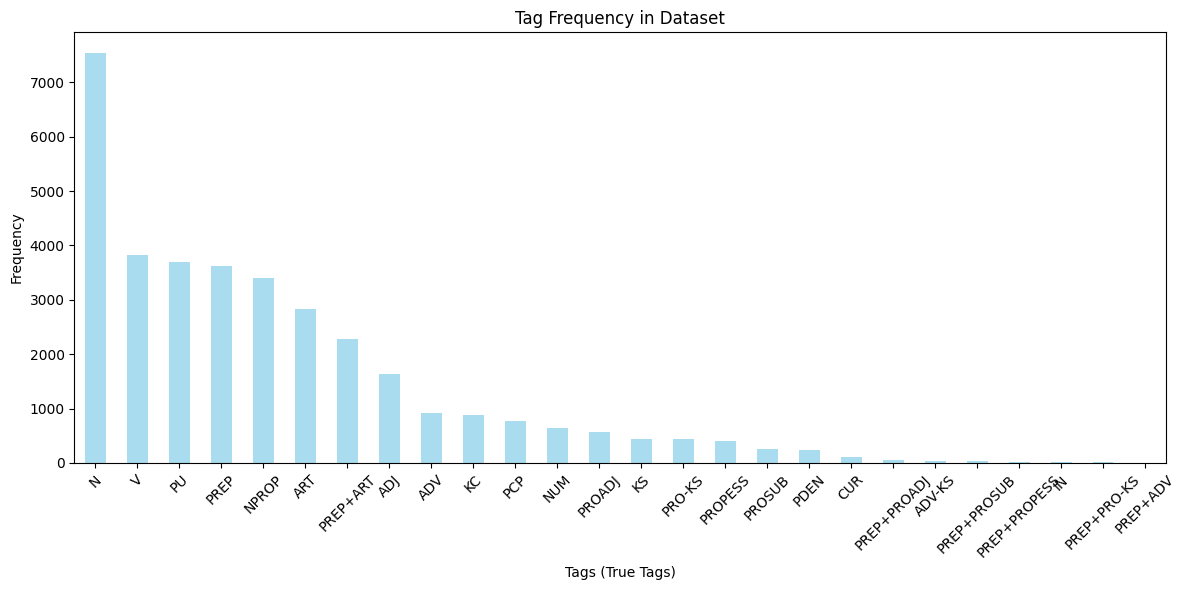

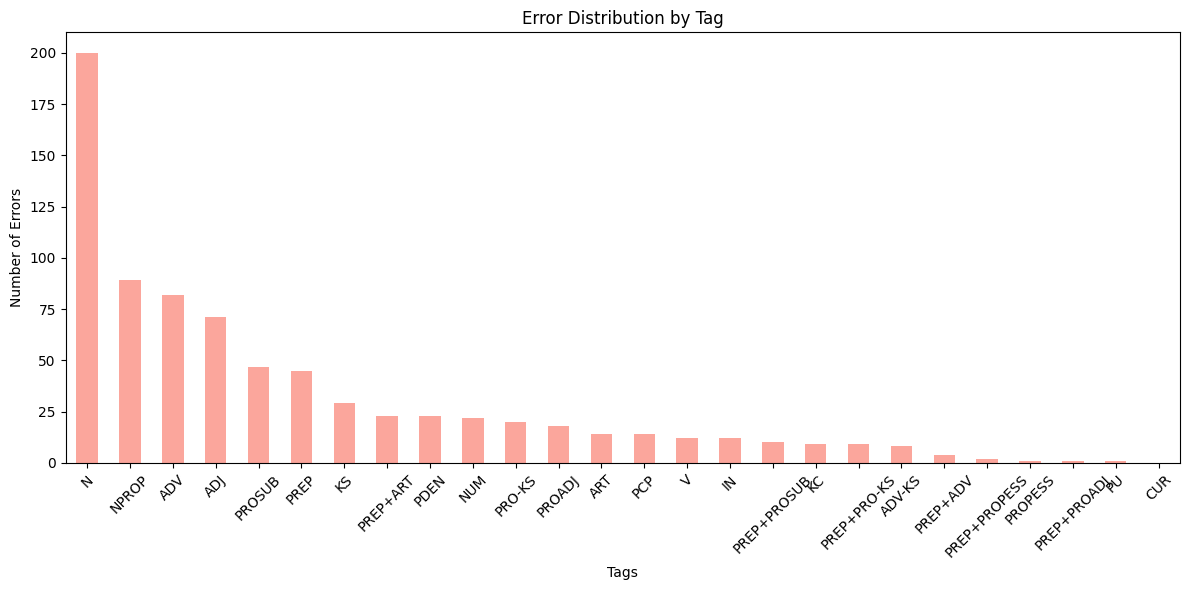

In [41]:
tag_frequency = df['True Tags'].value_counts()

plt.figure(figsize=(12, 6))
tag_frequency.plot(kind='bar', color='skyblue', alpha=0.7)
plt.xlabel('Tags (True Tags)')
plt.ylabel('Frequency')
plt.title('Tag Frequency in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df['Error'] = df['True Tags'] != df['Predicted Tags']
error_distribution = df.groupby('True Tags')['Error'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
error_distribution.plot(kind='bar', color='salmon', alpha=0.7)
plt.xlabel('Tags')
plt.ylabel('Number of Errors')
plt.title('Error Distribution by Tag')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

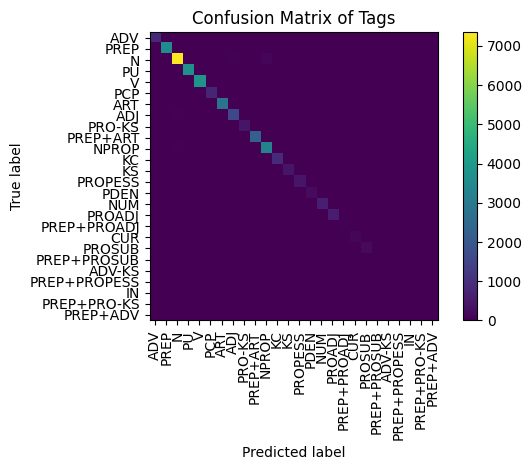

In [42]:
cm = confusion_matrix(df['True Tags'], df['Predicted Tags'], labels=df['True Tags'].unique())
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['True Tags'].unique())

plt.figure(figsize=(12, 10))
cmd.plot(cmap='viridis', xticks_rotation='vertical', colorbar=True, include_values=False)
plt.title('Confusion Matrix of Tags')
plt.tight_layout()
plt.show()


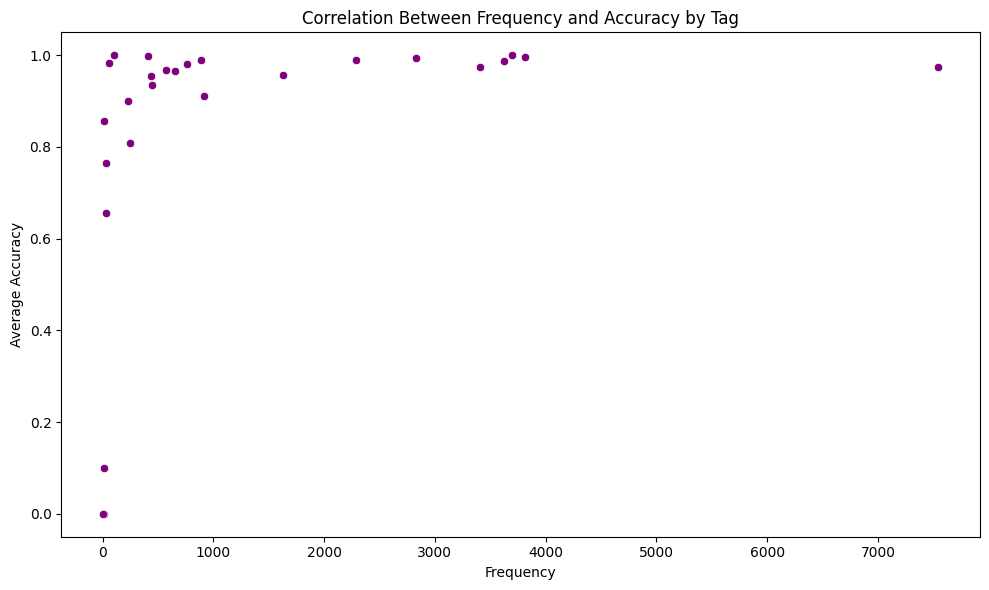

In [43]:
tag_freq_precision = df.groupby('True Tags').agg({'Word Accuracy': 'mean', 'True Tags': 'count'})
tag_freq_precision.columns = ['Average Accuracy', 'Frequency']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Average Accuracy', data=tag_freq_precision, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Average Accuracy')
plt.title('Correlation Between Frequency and Accuracy by Tag')
plt.tight_layout()
plt.show()


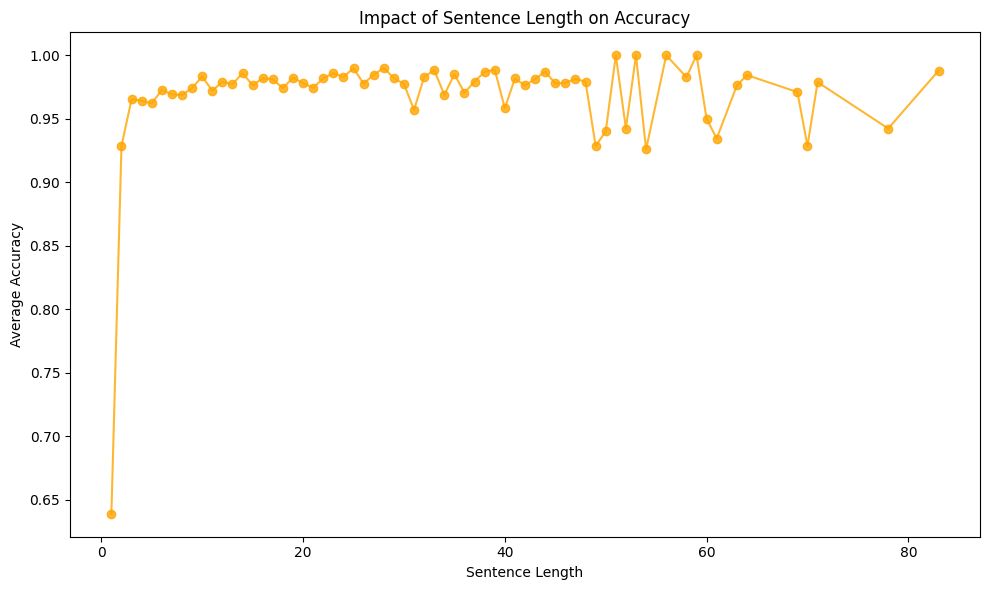

In [44]:
df['Sentence Length'] = df['Sentence'].str.split().apply(len)

length_vs_accuracy = df.groupby('Sentence Length')['Word Accuracy'].mean()

plt.figure(figsize=(10, 6))
plt.plot(length_vs_accuracy.index, length_vs_accuracy.values, marker='o', color='orange', alpha=0.8)
plt.xlabel('Sentence Length')
plt.ylabel('Average Accuracy')
plt.title('Impact of Sentence Length on Accuracy')
plt.tight_layout()
plt.show()


<>:1: SyntaxWarning: invalid escape sequence '\+'
<>:1: SyntaxWarning: invalid escape sequence '\+'
C:\Users\thais\AppData\Local\Temp\ipykernel_6904\3724494164.py:1: SyntaxWarning: invalid escape sequence '\+'
  poly_tags = df[df['True Tags'].str.contains('\+')]


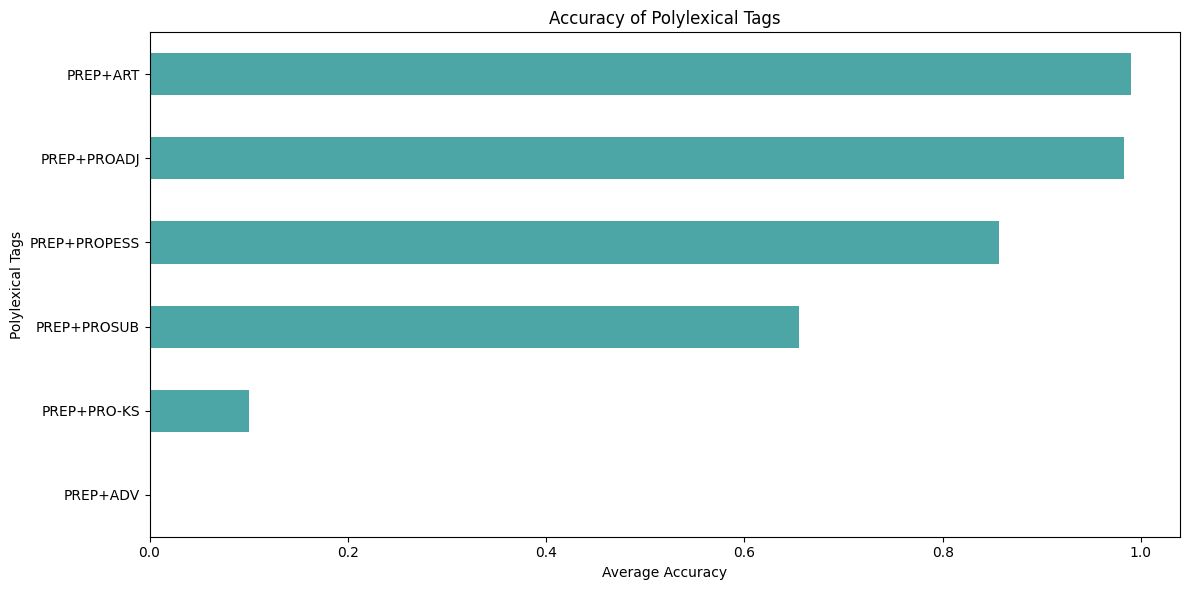

In [45]:
poly_tags = df[df['True Tags'].str.contains('\+')]

poly_accuracy = poly_tags.groupby('True Tags')['Word Accuracy'].mean()

plt.figure(figsize=(12, 6))
poly_accuracy.sort_values().plot(kind='barh', color='teal', alpha=0.7)
plt.xlabel('Average Accuracy')
plt.ylabel('Polylexical Tags')
plt.title('Accuracy of Polylexical Tags')
plt.tight_layout()
plt.show()


#### 3. Resultados de outros treinos

Infelizmente, **não mantive um registro detalhado dos treinamentos anteriores**, mas um aspecto fundamental que merece destaque é a influência do tamanho do conjunto de dados utilizados no processo de treinamento.

Inicialmente, realizei os testes utilizando apenas **500** sentenças aleatórias extraídas do conjunto de dados de treinamento, um número consideravelmente pequeno quando comparado à escala total dos dados disponíveis. Esse tamanho reduzido permitiu que o treinamento fosse concluído em **cerca de 2 minutos**, mas os resultados indicaram uma **acurácia modesta de aproximadamente 0.35**, refletindo a limitação do conjunto de dados na capacidade do modelo de aprender representações robustas.

Em seguida, aumentei a quantidade de sentenças para **10.000**. Com essa quantidade significativamente maior, o tempo de execução do treinamento foi ampliado para **aproximadamente 15 minutos**, mas, em contrapartida, **observei uma melhoria substancial na acurácia, que subiu para 0.91**. Esse avanço pode ser atribuído à maior diversidade e riqueza de informações proporcionadas por um número maior de exemplos, o que permitiu ao modelo aprender de forma mais eficaz as nuances das etiquetas de palavras.

Por fim, com o aumento para **20.000** sentenças aleatórias, **a acurácia continuou a crescer, alcançando uma média de 0.97**, mas não de forma tão expressiva quanto esperado. Além disso, o tempo de execução do código aumentou consideravelmente, **chegando a 45 minutos**. Essa ampliação no tempo de treinamento pode ser vista como um indicativo de que o modelo está começando a enfrentar limitações no tempo de processamento à medida que o volume de dados cresce.

Dado esse **aumento significativo no tempo de execução e a melhora mais modesta na acurácia, optei por não realizar testes com conjuntos de dados ainda maiores**. Isso se deve ao fato de que, a partir de um certo ponto, o impacto adicional na performance não parecia ser relevante o suficiente para justificar o tempo e os recursos computacionais necessários para processar volumes ainda maiores de dados.

## Conclusão

Na avaliação do modelo de POS Tagging desenvolvido, percebi que a precisão do modelo varia bastante de uma classe para outra, com resultados positivos em termos gerais. A acurácia média foi de 0.96 por sentença e 0.97 por palavra, o que é um bom indicativo do desempenho do modelo. Ao analisar os gráficos de distribuição de acurácia por tags, notei que até mesmo classes menos frequentes, como CUR (símbolo de moeda), apresentaram resultados consistentes. No entanto, algumas tags mais comuns, como N (substantivo), tiveram um desempenho bom, mas abaixo das expectativas. Isso pode ser atribuído à alta diversidade semântica e sintática dos substantivos, o que torna sua classificação mais desafiadora para o modelo.

As classes com maior precisão tendem a ter regras bem definidas e uma frequência mais alta no corpus. Por outro lado, as classes com menor precisão apresentam maior ambiguidade ou são menos frequentes no corpus.

A análise também mostrou que há uma relação clara entre a frequência das classes no corpus e a precisão do modelo. Classes como N (nome), V (verbo) e ART (artigo), que aparecem com mais frequência, têm uma precisão moderada a alta. Já classes com baixa frequência, como ADV-KS (advérbio conectivo subordinativo) e PREP+ADV, apresentam uma precisão mais baixa.

Vale destacar que, apesar de as palavras mais frequentes terem uma precisão maior, também houve um número significativo de erros nessas classes, devido à sua maior ocorrência nos testes.

Além disso, o gráfico de acurácia por comprimento de sentença mostrou que sentenças mais longas tendem a apresentar variações na acurácia, provavelmente devido à maior complexidade estrutural. Durante o treinamento, o gráfico combinando perda de treinamento, validação e acurácia revelou uma melhoria consistente até cerca de 250 steps. Após esse ponto, a curva entrou em estagnação e apresentou uma leve piora na validação, sugerindo o início de overfitting.